### Model 1

In [1]:
# imports
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

In [2]:
df = pd.read_csv('./Data/subreddit_data_post_eda.csv')

In [3]:
df.head()

,title,selftext,subreddit,title_length,title_word_count,sentiment_compound,sentiment_negative,sentiment_neutral,sentiment_positive
0,"I was suggested to post this puzzle here ,hope...",NaN,0,65,14,0.8126,0.000,0.543,0.457
1,Programs for analyzing and annotating my games,"Hi all, \n\n&amp;#x200B;\n\nI am starting to t...",0,46,7,0.0000,0.000,1.000,0.000
2,Who is GM Watneg on lichess?,NaN,0,28,6,0.0000,0.000,1.000,0.000
3,Glitch in Lichess Analysis,&amp;#x200B;\n\n[I was playing a game continua...,0,26,4,0.0000,0.000,1.000,0.000
4,Does anyone know what the heck a zero day that...,Someone sent me something weird about correlat...,0,162,34,-0.5043,0.121,0.879,0.000


In [4]:
# Baseline Model.  We need to beat 50%.
df['subreddit'].value_counts(normalize = True)

1    0.500375
0    0.499625
Name: subreddit, dtype: float64

In [6]:
# Create X and Y for CountVectorizer

X = df.drop(columns = ['subreddit'])
y = df['subreddit']

In [7]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [8]:
def get_title(df):
    return df['title']

get_title_transformer = FunctionTransformer(get_title, validate = False)

In [9]:
def other_columns(df):
    return df[['title_length', 'sentiment_compound', 'title_word_count']]

get_columns_transformer = FunctionTransformer(other_columns, validate = False)

In [10]:
# Create Pipeline

pipe_cv = Pipeline([
    ('title_transform', get_title_transformer),
    ('vect', CountVectorizer())
])

In [11]:
outer_pipe = Pipeline([
    ('feats', FeatureUnion([
        ('vect_pipe', pipe_cv),
        ('other_cols', get_columns_transformer)
    ])),
    ('model', LogisticRegression())
])

In [12]:
param_grid = {
    'model__max_iter': [1000],
    'feats__vect_pipe__vect__max_features': [None, 4000, 5000],
    'feats__vect_pipe__vect__min_df' : [2,3],
    'feats__vect_pipe__vect__max_df' : [.90],
    #'feats__vect_pipe__vect__ngram_range' : [(1,1),(1,2)]
    #'feats__vect_pipe__vect__token_pattern': ['(?u)\\b\\w\\w+\\b', '[A-Z][a-z]+']
}
gs = GridSearchCV(outer_pipe, param_grid=param_grid)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.935265998887034


{'feats__vect_pipe__vect__max_df': 0.9,
 'feats__vect_pipe__vect__max_features': None,
 'feats__vect_pipe__vect__min_df': 2,
 'model__max_iter': 1000}

In [13]:
# Investigate coefficients (remember bc of logreg, we'll ultimately have to np.exp them)

gs.best_estimator_.named_steps['model'].coef_

# got the coefficients, now need the feature names before zipping them together.

array([[-0.28377789, -0.13136288, -0.06332175, ...,  0.00419584,
         0.0643139 ,  0.09694436]])

In [13]:
# How do i get feature names of all the columns created by the CountVectorizer??
gs.best_estimator_.named_steps['feats'].get_support(indices=True)

AttributeError: 'FeatureUnion' object has no attribute 'get_support'

### Try a Bagging Classifier?

In [ ]:
# Instantiate BaggingClassifier.
bag = BaggingClassifier(base_estimator = DecisionTreeClassifier())
# Fit BaggingClassifier.
bag.fit(X_train, y_train) # whole for loop that we did earlier, its happening here in this one line of code
# Score BaggingClassifier.
bag.score(X_test, y_test)

### Model Evaluation

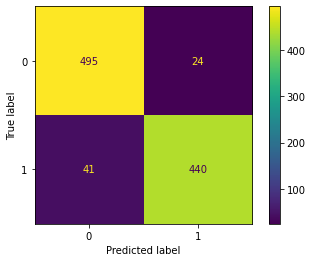

In [12]:
plot_confusion_matrix(gs, X_test, y_test)

In [13]:
# Make predictions
predictions = gs.predict(X_test)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       519
           1       0.95      0.91      0.93       481

    accuracy                           0.94      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.94      0.93      1000



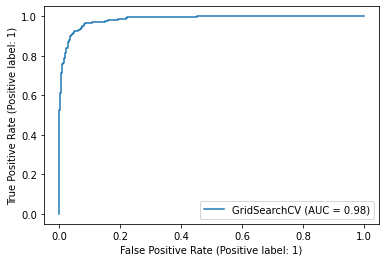

In [15]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(gs, X_test, y_test);